In [1]:
# MA Cross Backtesting on 1H EURUSD, maps signals from higher timeframe to lower granularity timeframe
# - Spread                  is in the lower 1m timeframe, it will dynamically charge
# - Initial capital         is 10000.0$
# - Position size per trade is 2% of account
# - Timeframe               is 1H
# 

In [2]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [3]:
df_ = pd.read_csv("./data/EURUSD.csv", parse_dates=True, index_col="datetime")
df_

,Open,High,Low,Close,Volume,Spread
datetime,,,,,,
2009-10-20 04:14:00+00:00,1.49814,1.49816,1.49812,1.49812,12,17
2009-10-20 04:15:00+00:00,1.49810,1.49822,1.49806,1.49820,24,16
2009-10-20 04:16:00+00:00,1.49819,1.49820,1.49805,1.49807,22,16
2009-10-20 04:17:00+00:00,1.49805,1.49805,1.49801,1.49803,6,16
2009-10-20 04:18:00+00:00,1.49801,1.49801,1.49789,1.49799,28,16
...,...,...,...,...,...,...
2023-10-16 03:35:00+00:00,1.05200,1.05206,1.05197,1.05206,21,9
2023-10-16 03:36:00+00:00,1.05206,1.05217,1.05206,1.05217,12,9
2023-10-16 03:37:00+00:00,1.05217,1.05217,1.05214,1.05217,6,9


In [4]:
hours               = 1
timeframe_by_minute = hours*60
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2009-10-20 04:00:00+00:00,1.49814,1.49822,1.49644,1.49725,1002
2009-10-20 05:00:00+00:00,1.49724,1.49846,1.49653,1.49805,1534
2009-10-20 06:00:00+00:00,1.49804,1.49808,1.49657,1.49781,1879
2009-10-20 07:00:00+00:00,1.49785,1.49870,1.49655,1.49857,3018
2009-10-20 08:00:00+00:00,1.49855,1.49866,1.49560,1.49613,3128
...,...,...,...,...,...
2023-10-15 23:00:00+00:00,1.05213,1.05222,1.05168,1.05216,745
2023-10-16 00:00:00+00:00,1.05218,1.05234,1.05153,1.05173,1564
2023-10-16 01:00:00+00:00,1.05173,1.05251,1.05173,1.05216,1319


In [5]:
# Signal extraction

df['MA50' ] = df['Close'].rolling(window=20).mean()
df['MA200'] = df['Close'].rolling(window=50).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [6]:
df['Signal'].value_counts()

Signal
 0    85438
-1      976
 1      975
Name: count, dtype: int64

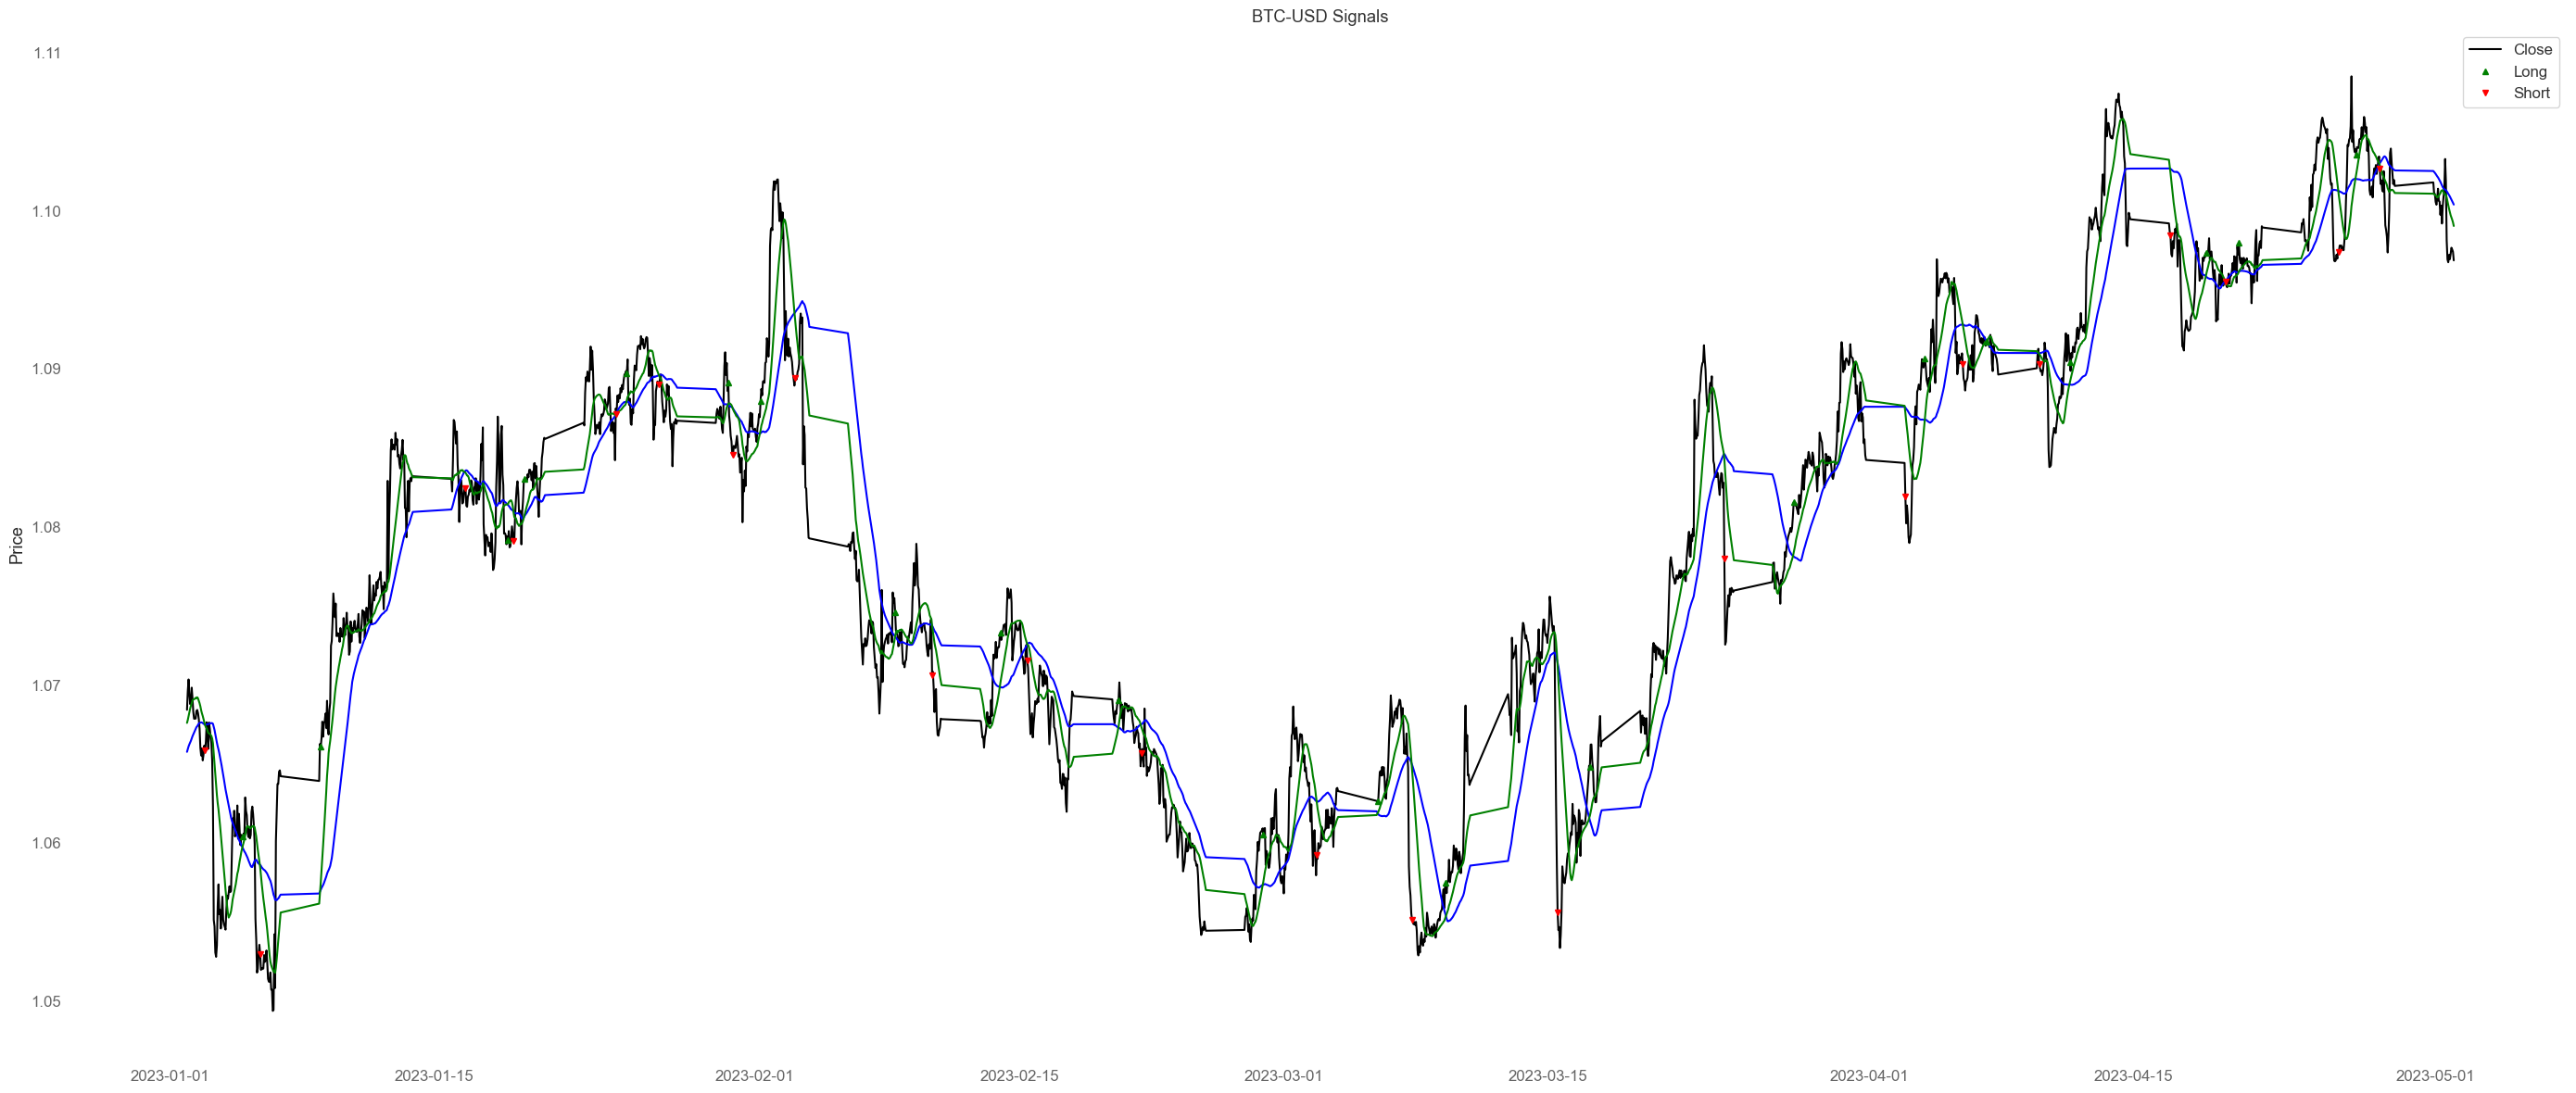

In [7]:
plot_df = df["2023-01-01":"2023-05-01"]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=5, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=5, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [8]:
# Saving signals extracted on higher timeframe to lower granularity timeframe

df_eval = df_.copy(deep=True)

df_eval['Signal'] = 0

for idx, row in df[df['Signal']== 1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = 1

for idx, row in df[df['Signal']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = -1

look_ahead_shift = 1
df_eval['Signal' ] = df_eval['Signal' ].shift(hours*60+look_ahead_shift)

df_eval.dropna(inplace=True)

In [9]:
df_eval['Signal'].value_counts()

Signal
 0.0    5177031
-1.0        955
 1.0        952
Name: count, dtype: int64

In [15]:
eurusd_pip_move     = 0.0001

position            = 0
entry_timestamp     = None
entry_price         = 0
exit_timestamp      = None
exit_price          = 0
is_available        = True
position_history    = []

for index, row in df_eval[(df_eval['Signal']!=0)].iterrows():
    # Exit position
    if position != 0 and is_available==False:
        exit_timestamp   = index
        exit_price       = row['Close'] 
        pct_change       = ((exit_price - entry_price) / entry_price * 100) * position
        is_available     = True
        position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change, position))

    # Open new long position
    if row['Signal'] == 1 and is_available==True:
        spread_by_pips   = row['Spread']
        spread_cost_move = spread_by_pips  * eurusd_pip_move
        entry_price      = row['Close'] + spread_cost_move

        entry_timestamp  = index
        is_available     = False
        position         = 1

    # Open new short position
    if row['Signal'] == -1 and is_available==True:
        spread_by_pips   = row['Spread']
        spread_cost_move = spread_by_pips  * eurusd_pip_move
        entry_price      = row['Close'] - spread_cost_move

        entry_timestamp  = index
        is_available     = False
        position         = -1



position_df = pd.DataFrame(position_history, columns=['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price', 'Pct Change', 'Position'])
position_df['cumret'] = position_df['Pct Change'].cumsum()

In [16]:
initial_capital    = 10000.0 # Initial capital in dollars
commission_fee     = 0.0     # 0.0 because broker will charge through the spread instead of commission
position_per_trade = 0.02    # 2% of position size per trade

account_balance = initial_capital
balance_changes = []

# Iterate through each trade in the position history
for index, trade in position_df.iterrows():
    pct_change       = trade['Pct Change']
    position_size    = account_balance * position_per_trade
    dollar_change    = position_size * pct_change
    commission       = position_size * (commission_fee/100.0)
    balance_change   = dollar_change - commission
    account_balance += balance_change
    balance_changes.append(balance_change)

position_df['Balance Change' ] = balance_changes
position_df['Account History'] = initial_capital + position_df['Balance Change'].cumsum()
position_df['Entry Time'     ] = pd.to_datetime(position_df['Entry Time'])
position_df = position_df.set_index('Entry Time')

position_df['Account Change'] = position_df['Account History'].pct_change()

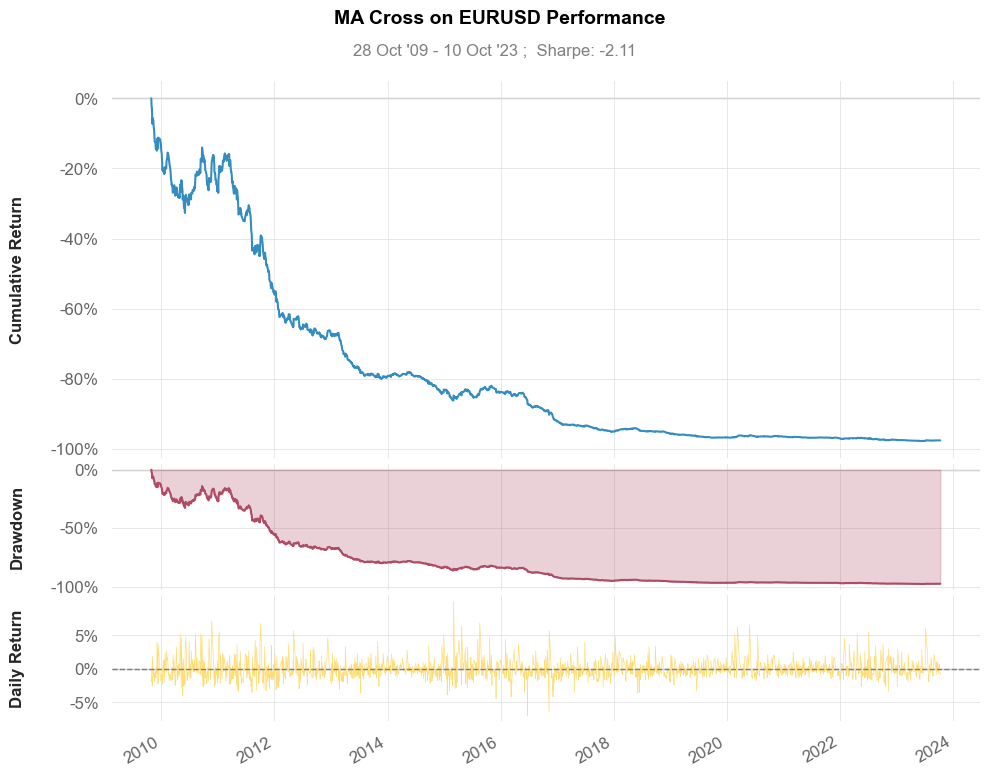

In [17]:
qs.plots.snapshot(position_df['Account Change'], title='MA Cross on EURUSD Performance', show=True);

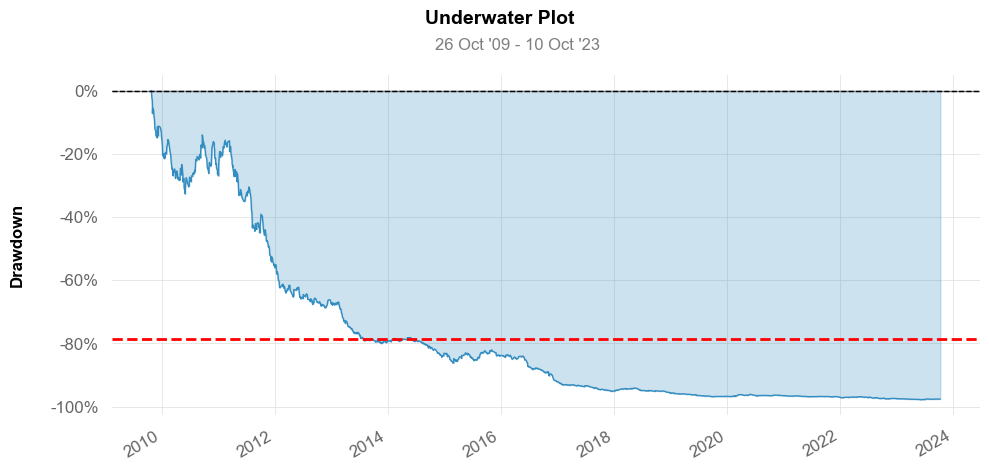

In [18]:
qs.plots.drawdown(position_df['Account Change'])

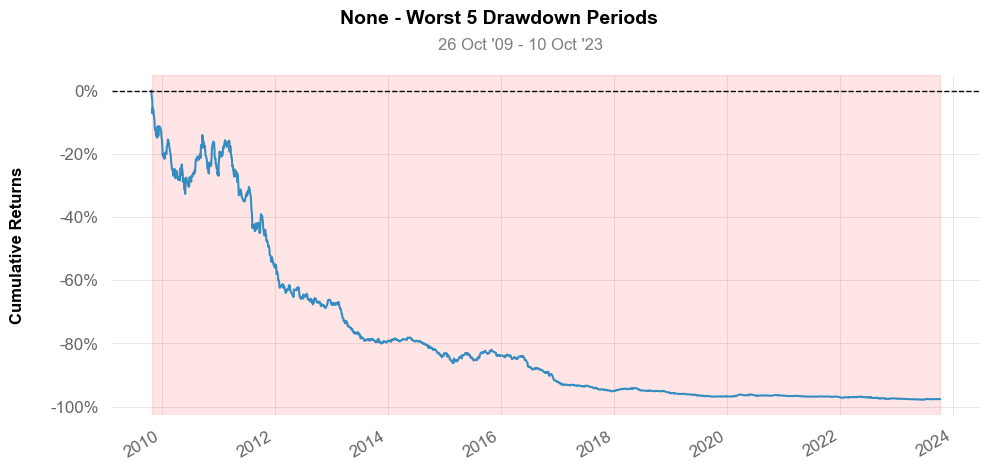

In [19]:
qs.plots.drawdowns_periods(position_df['Account Change'])

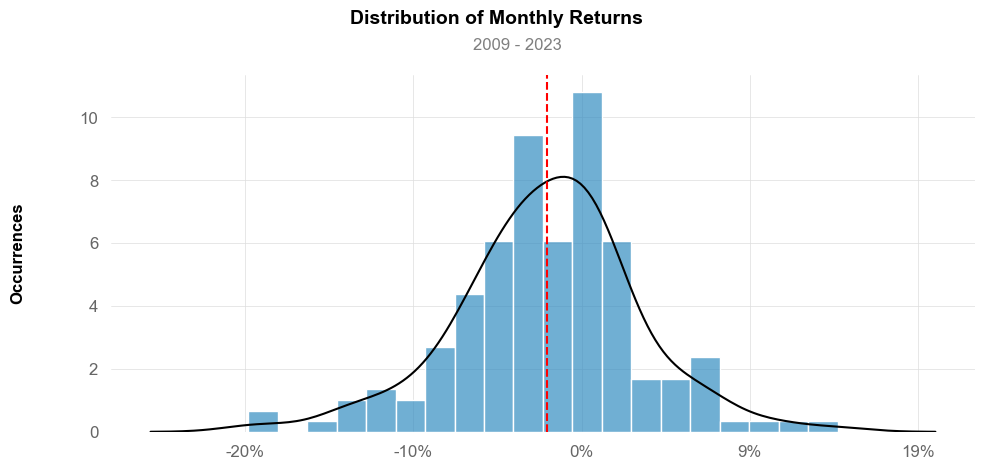

In [20]:
qs.plots.histogram(position_df['Account Change'])

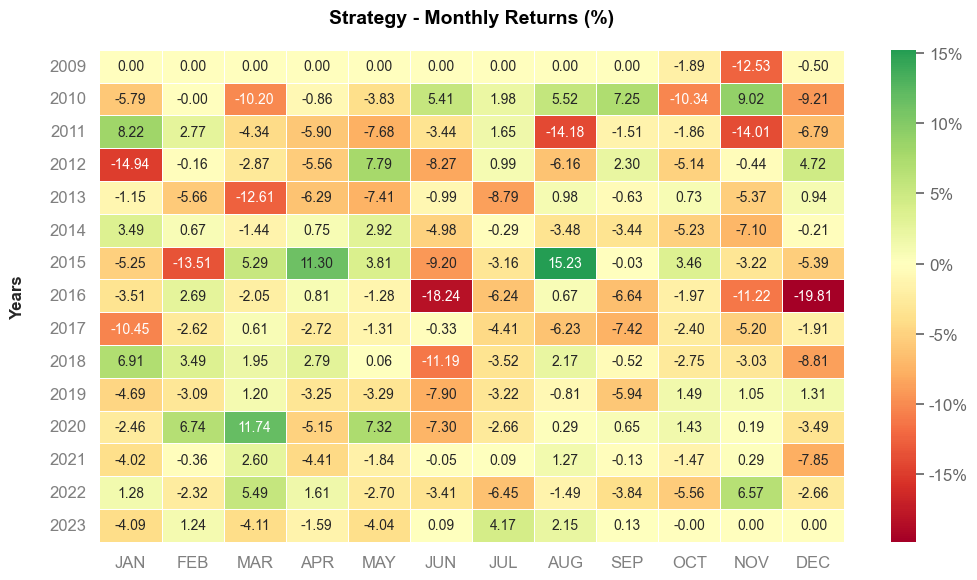

In [21]:
qs.plots.monthly_heatmap(position_df['Account Change'])

In [22]:
qs.stats.sharpe(position_df['Account Change'])

-2.1123113880502973